# Tarea del Dia 3. Machine Learning
Utilizaremos el dataset del precio de casas para crear un modelo que predizca el precio de estas

## 1. Importacion de los datos y pre-procesado

### 1.1. Importación de los datos

Antes de nada creamos una linia donde se enuentra el ```path``` de nuestro archivo para poder utilizar los caminos relativos para importar los [datos](https://www.kaggle.com/fedesoriano/the-boston-houseprice-data).

**Importante**: El usuario debe comprobar que el ```data_path``` es el adecuado. En caso de que no lo sea debe modificar la celda siguiente para que sea correcto.

In [16]:
import os

ipynb_path = os.path.dirname(os.path.realpath("__file__"))
data_path = ipynb_path + "/Data/Precios_casas.csv"
print(data_path)

/media/eloisanchez/ELOI/UNED/Cursos de Extension/Python Avanzado/Tareas/Dia_3/Data/Precios_casas.csv


Importamos el archivo en formato dataframe

In [17]:
import pandas as pd

casasDf = pd.read_csv(data_path, sep=';', decimal=',')

### 1.2. Pre-procesado de datos

Realizamos un pre-procesado de los datos y la separación entre la variable que quedemos predecir y las que utilizamos para predecirla. En este caso elegimos como variable dependiente (la *y*) el precio de las casas ```MEDV``` (*Mean-Value of owner occupied homes in $1000's (k\$)*).

Primero, el eliminamos los posibles NANs de los datos interpolando. Hacemos esto por que no tenemos demasiados datos y eliminarlos reduciría aun mas nuestra muestra.

In [18]:

if casasDf.isna().any().any():
    casasDf = casasDf.interpolate()

if casasDf.isna().any().any():
    print("ERROR: After NaN processing, still NaN have been found")

Analizamos la correlación de las variables y eliminamos aquellas con una correlacion menor que 0.2 (valor *arbitrario*).

In [19]:
print(f'Initial columns: {casasDf.columns}')

# Obtenemos vector de correlaciones
corr = casasDf.corr().loc['MEDV']

# Eliminamos las columnas donde la correlacion es menor que un threshold arbitrario
casasDf = casasDf.drop(corr.index[corr.abs() < 0.2], axis=1)

print(f'\nFinal columns: {casasDf.columns}')


Initial columns: Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

Final columns: Index(['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')


Separamos la  variable dependiente (en el vector *y*) y las demás (en la matriz *X*)

In [20]:
import numpy as np

X_valuesDf = casasDf.drop('MEDV', axis=1)
y_valuesDf = casasDf.loc[:, 'MEDV']

X_values = np.array(X_valuesDf)
y_values = np.array(y_valuesDf)

Simplemente por analizar algunas tendencias interesantes, veamos los plots de las tres variables con correlaciones mayores positivas y las mayores negativas.

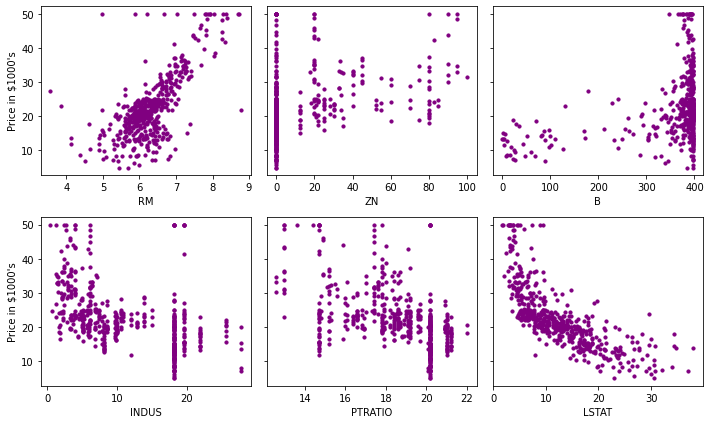

In [21]:
import matplotlib.pyplot as plt

def plotserie(ax, x, y, lab):
    ax.scatter(x[lab], y, s=10, color='purple')
    ax.set_xlabel(lab)

corr_sort = corr.sort_values(ascending=False)
pos_labels = corr_sort[1:4].index
neg_labels = corr_sort[-3:].index

fig_corr, ax_corr = plt.subplots(2,3, figsize=(10,6), sharey=True)

for i in range(len(pos_labels)):
    plotserie(ax_corr[0,i], X_valuesDf, y_valuesDf, pos_labels[i])

for j in range(len(neg_labels)):
    plotserie(ax_corr[1,j], X_valuesDf, y_valuesDf, neg_labels[j])

ax_corr[0,0].set_ylabel("Price in $1000's")
ax_corr[1,0].set_ylabel("Price in $1000's")

plt.tight_layout()
plt.show()


Por último, antes de empezar con los modelos de ML, realizamos una transformación de nuestros datos. Escalamos nuestros valores para que esten todos en el intervalo [0,1]. Separamos tambien nuestros datos en 2 partes, una para hacer el *fitting/training* y otra para hacer testear.

In [22]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy import stats

# Creamos los escaladors para nuestros valores
x_scaler = MinMaxScaler().fit(X_values)
y_scaler = MinMaxScaler().fit(y_values.reshape(-1,1))

# Hacemos el escalado de nuestras variables
X_values = x_scaler.transform(X_values)
y_values = y_scaler.transform(y_values.reshape(-1,1))


Analizamos y eliminamos los outliers utilizando el método del zscore.

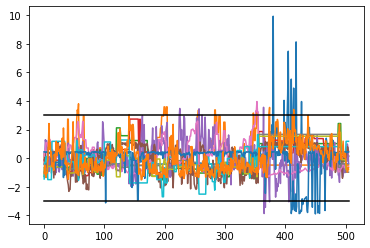

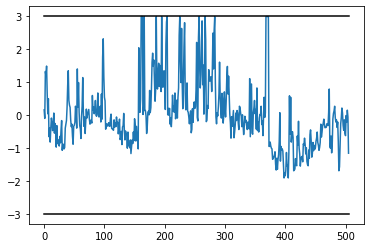

In [23]:

# Eliminamos los outliers utilizando el zscore
y_zscores = stats.zscore(y_valuesDf)
X_zscores = stats.zscore(X_valuesDf)

n = len(y_zscores)

plt.plot(X_zscores)
plt.plot(np.arange(n), np.ones(n) * 3, c='black')
plt.plot(np.arange(n), np.ones(n) * (- 3), c='black')
plt.show()

plt.plot(y_zscores)
plt.plot(np.arange(n), np.ones(n) * 3, c='black')
plt.plot(np.arange(n), np.ones(n) * (-3), c='black')
plt.show()

# TODO Falta eliminar los outliers, pero quiero comentarlo con el profesor antes por que no lo termino de entender.

Separamos los datos en dos subgrupos, uno de entrenamiento y el otro de testeo.

In [24]:
# Separamos los datos en un set de entrenamiento y otro de testeo
X_train, X_test, y_train, y_test = train_test_split(X_values, y_values, test_size=0.15, random_state=17)

if not y_train.size + y_test.size == y_values.size:
    raise ValueError(f'''The train/test splitting is not correct.\ny_values={y_values.size}\ny_test={y_test.size}\ny_train={y_train.size}''')

Con esto hemos terminado el procesado de datos inicial
___
## 2. Modelados
Primero creamos una función para hacer un plot con los resultados de nuestros modelos y un print de los resultados importantes.


In [36]:
from sklearn import metrics

def checkmodel(ax_plot, ax_err, y_pred, y_real, x=None, title=''):
    if x == None:
        x = range(len(y_real))
    ax_plot.plot(x, y_real, label="Real Values")
    ax_plot.plot(x, y_pred, label="Prediction")
    ax_plot.legend()
    ax_plot.set_title(title)
    ax_plot.set_ylabel("Price in $1000's")
    ax_err.plot(x, 100 * (y_pred - y_real) / y_real)
    ax_err.set_ylabel('Relative error (%)')
    ax_err.set_title(f'Error for {title}')
    plt.tight_layout()
    plt.show()
    
    rmse = (np.sqrt(metrics.mean_squared_error(y_real, y_pred)) / y_real).mean()
    print(f'The Root Mean Squared Error of the {title} model is {rmse:.2%}')

### 2.1. Linear fit
Primero realizaremos un analisis de regresion lineal

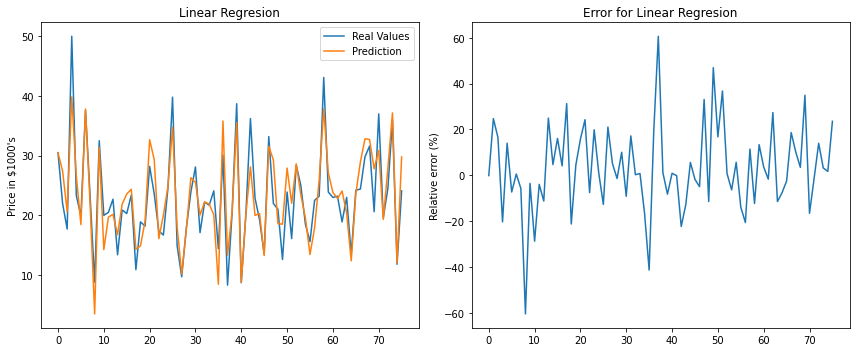

The Root Mean Squared Error of the Linear Regresion model is 18.37%


In [39]:
from sklearn import linear_model

# Obtengo los valores de y reales (aplicando la transf. inversa) para comparar con los predichos
y_test_real = y_scaler.inverse_transform(y_test)

# Entrenamos el modelo lineal (Hacemos una regression normal i corriente de varias variables)
linModel = linear_model.LinearRegression()
linModel = linModel.fit(X_train, y_train)

# Predecimos nuestros valores
y_pred_lin = linModel.predict(X_test)

# Transformamos los datos a nuestro valor no escalado (el real)
y_pred_lin = y_scaler.inverse_transform(y_pred_lin)

# Comprobamos el modelo
fig_lin, ax_lin = plt.subplots(1, 2, figsize=(12,5))
checkmodel(ax_lin[0], ax_lin[1], y_pred_lin, y_test_real, title='Linear Regresion')

### 2.2. Random Forest
Ahora utilizamos el modelo random forest. El proceso es, a efectos prácticos, el mismo que en el caso anterior.

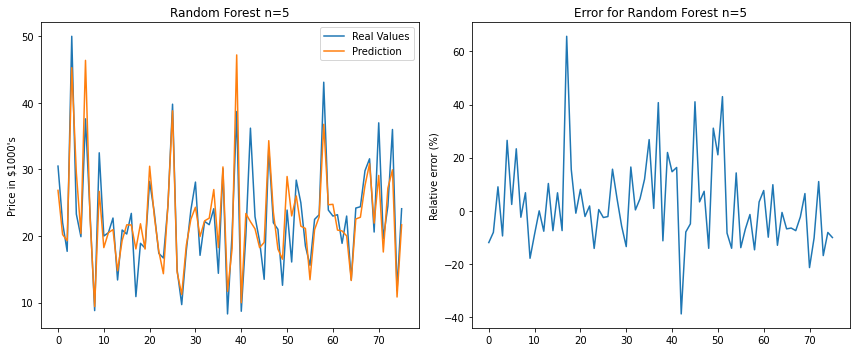

The Root Mean Squared Error of the Random Forest n=5 model is 18.09%


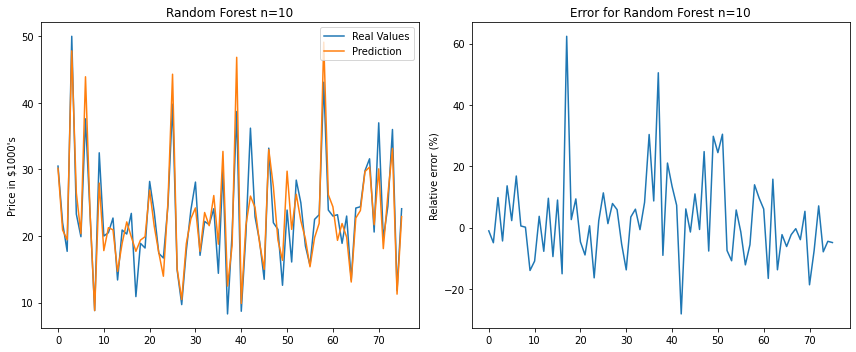

The Root Mean Squared Error of the Random Forest n=10 model is 15.39%


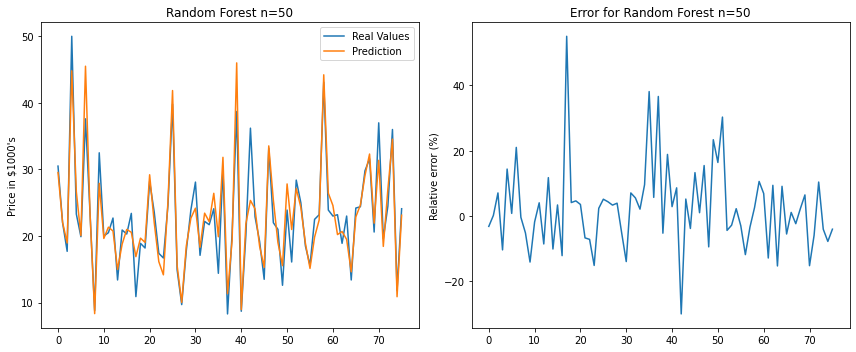

The Root Mean Squared Error of the Random Forest n=50 model is 14.16%


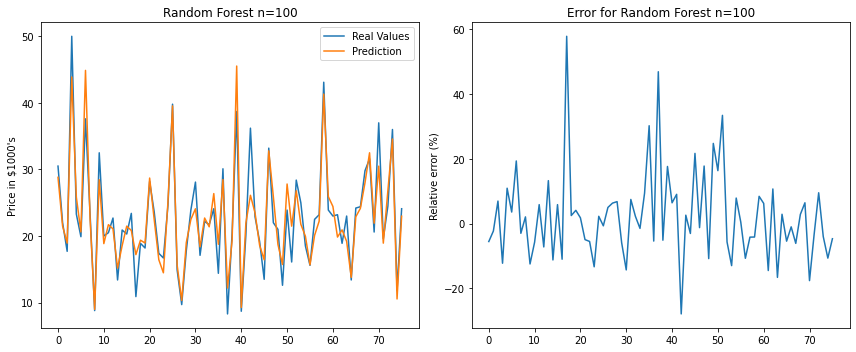

The Root Mean Squared Error of the Random Forest n=100 model is 14.24%


In [44]:
from sklearn.ensemble import RandomForestRegressor

def ranForestReg(x_train, y_train, x_test, y_real, n=[5, 10, 50, 100]):
    for i in n:
        # Entrenamos el modelo Random Forest 
        ranForModel = RandomForestRegressor(n_estimators=i)
        ranForModel = ranForModel.fit(x_train, y_train.ravel())

        # Predecimos nuestros valores
        y_pred_ranFor = ranForModel.predict(x_test)

        # Transformamos los datos a nuestro valor no escalado (el real)
        y_pred_ranFor = y_scaler.inverse_transform(y_pred_ranFor.reshape(-1,1))

        # Comprobamos el modelo
        fig_ranFor, ax_ranFor = plt.subplots(1, 2, figsize=(12,5))
        checkmodel(ax_ranFor[0], ax_ranFor[1], y_pred_ranFor, y_real, title=f'Random Forest n={i}')

ranForestReg(X_train, y_train, X_test, y_test_real)

### 2.3. Comparación final
Comprobamos como el Random Forest funciona un mejor que la regresión lineal, pero cabe destacar que esta no funciona mal tampoco. Además, también vemos como aumentar el numero de arboles en el Random Forest hace que aumente su precision al pasar de ```n=5``` a ```n=10``` y a ```n=50```, pero al pasar a ```n=100``` ya no hay mejora.